# Model developement to predict the rating (user review) of a movie: Part-III  (applying PCA and selecting 95% features)

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA

In [2]:
# Import the datasets
IMDB_only = pd.read_csv('pre-processed_dataset/IMDB_only.csv', index_col = 0)
IMDB_Kaggle_common = pd.read_csv('pre-processed_dataset/IMDB_Kaggle_common.csv', index_col = 0)

In [ ]:
#IMDB_only.shape, IMDB_Kaggle_common.shape

In [3]:
y = IMDB_only['avg_vote']
X = IMDB_only.drop(columns = 'avg_vote')

In [4]:
print(X.shape)
print(y.shape)

(69458, 1088)
(69458,)


## Train test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape)
print(X_test.shape)

(48620, 1088)
(20838, 1088)


In [6]:
# PCA with all default arguments
pca = PCA()
pca1 = pca.fit(X_train)
pca1_train = pca1.transform(X_train)
pca1_test = pca1.transform(X_test)
variance = pca1.explained_variance_ratio_
variance[:15]

array([0.30476809, 0.16820868, 0.05150449, 0.04209438, 0.0350429 ,
       0.02627028, 0.0226602 , 0.02032903, 0.01607263, 0.01553961,
       0.01414742, 0.01269597, 0.01074852, 0.00992601, 0.00939499])

**To decide the number of PCA components for model development, propotion of PCA variance and cumsum PCA variance were plotted below:**

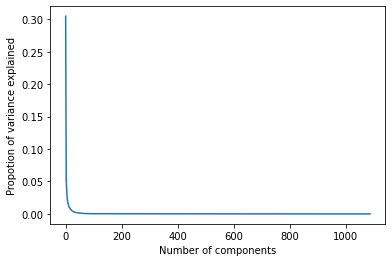

In [7]:
# Plot the variance
plt.plot(range(len(variance)), variance)
plt.xlabel('Number of components')
plt.ylabel('Propotion of variance explained')
plt.show()

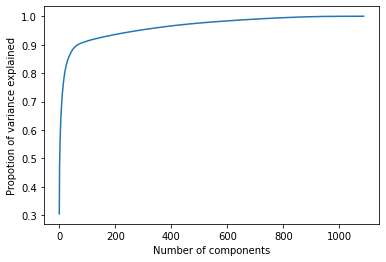

In [8]:
# Plot the variance
cum_sum_variance = np.cumsum(variance)
plt.plot(range(len(variance)), cum_sum_variance)
plt.xlabel('Number of components')
plt.ylabel('Propotion of variance explained')
plt.show()

In [9]:
value_95 = sum(cum_sum_variance < .95) + 1

In [10]:
value_95

283

In [11]:
pca_transformed_train = pca1_train[:, 0:283]
pca_transformed_test = pca1_test[:, 0:283]

### Simple Linear Regression

In [12]:
lr = LinearRegression()
lr.fit(pca_transformed_train, y_train)
y_train_predict = lr.predict(pca_transformed_train)
y_test_predict = lr.predict(pca_transformed_test)

In [13]:
np.max(y_train_predict), np.max(y_test_predict) 


(9.410929909586567, 8.891105234202907)

In [14]:
lr.intercept_, sorted(lr.coef_)[:10]

(5.914574249280131,
 [-1.506991842943516,
  -1.1914066568868202,
  -1.0023615951153206,
  -0.9042285402127718,
  -0.7624483575096344,
  -0.6552767858951075,
  -0.6355618515189914,
  -0.6161091786699772,
  -0.5843402229012397,
  -0.5592339912742011])

In [15]:
r2_score(y_train, y_train_predict), r2_score(y_test, y_test_predict)


(0.3995590223370583, 0.4028107563413297)

In [ ]:
#With default PCA, taking 10 features out of it, give r2(train) = 0.282, r2(test) = 0.297
#With default PCA, taking 300 features out of it, give r2(train) = 0.40069324204273205, r2(test) = 0.40332469399338367 
#With default PCA, taking 500 features out of it, give r2(train) = 0.41206037587239575, r2(test) = 0.40868072906102304 
#With default PCA, taking 700 features out of it, give r2(train) = 0.42215258292459845, r2(test) = 0.4159146133560834 
#With default PCA, taking 750 features out of it, give r2(train) = 0.42423581513519304, r2(test) = 0.41732864600822994 
#With default PCA, taking 800 features out of it, give r2(train) = 0.4263313726644138, r2(test) = 0.41905434499205096
#With default PCA, taking 900 features out of it, give r2(train) = 0.42897799913686985, r2(test) = 0.42144591773069895
#With default PCA, taking 1000 features out of it, give r2(train) = 0.43032786009086554, r2(test) = 0.42158088617178713
#With default PCA, taking 1088 features out of it, give r2(train) = 0.4289203631442904, r2(test) = -7.683747921219262e+20

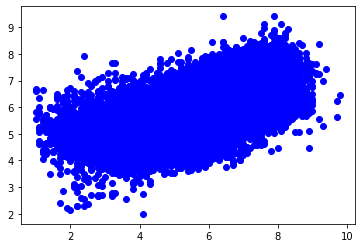

In [16]:
#plot the y_test and y_predict
plt.scatter(y_train,y_train_predict,  color = 'b')
plt.show()

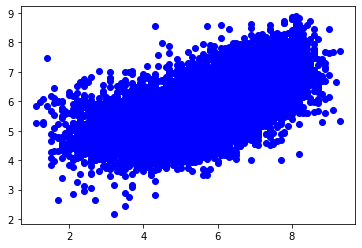

In [17]:
#plot the y_test and y_predict
plt.scatter(y_test,y_test_predict,  color = 'b')
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error
print("The mean squared error:", mean_squared_error(y_test, y_test_predict))

from sklearn.metrics import mean_squared_error
print("The root mean squared error:", mean_squared_error(y_test, y_test_predict, squared = False))

from sklearn.metrics import mean_absolute_error
print("The mean absolute error:", mean_absolute_error(y_test, y_test_predict))

The mean squared error: 0.8749012246597593
The root mean squared error: 0.9353615475631651
The mean absolute error: 0.7151024696927785


### Lasso Linear Regression

In [19]:
alpha = [0.01, 0.1, 1, 10]
for alp in alpha:
    lasso1 = Lasso(alpha=alp)
    lasso1.fit(pca_transformed_train, y_train)
    y_train_predict1 = lasso1.predict(pca_transformed_train)
    y_test_predict1 = lasso1.predict(pca_transformed_test)
    print(alp)
    print(r2_score(y_train, y_train_predict1))
    print(r2_score(y_test, y_test_predict1))

0.01
0.31286170993203344
0.3257262774935512
0.1
0.20527182235787633
0.214858489924854
1
0.0
-0.00026864922856795204
10
0.0
-0.00026864922856795204


In [20]:
alpha2 = [0.01, 0.1, 1, 10, 20, 30, 50]
for alp2 in alpha2:
    Rge = Ridge(alpha=alp2)
    Rge.fit(pca_transformed_train, y_train)
    y_train_predict2 = Rge.predict(pca_transformed_train)
    y_test_predict2 = Rge.predict(pca_transformed_test)
    print(alp2)
    print(r2_score(y_train, y_train_predict2))
    print(r2_score(y_test, y_test_predict2))
    print(np.max(y_test_predict2))

0.01
0.3995590215940683
0.4028113630844593
8.890982119642919
0.1
0.39955894825254756
0.40281675094960545
8.889875548230886
1
0.3995518228800504
0.4028636340125846
8.87895221186604
10
0.39900416280239814
0.4028022383427061
8.856102320289844
20
0.3978242906780377
0.4020711460270372
8.855297966922777
30
0.3964060634623989
0.40103178453029487
8.853352018388074
50
0.39343368377801424
0.39867394849548365
8.847480213164035


In [21]:
# Applying GridSearchCV
Rge3 = Ridge()
alpha = [0.01, 0.1, 1, 0, 20, 30]
parameters = {'alpha': alpha}
rge3_grid = GridSearchCV(Rge3, param_grid = parameters, scoring = 'r2', cv = 5)
rge3_grid.fit(pca_transformed_train, y_train)

print(rge3_grid.best_score_)
print(rge3_grid.best_params_)

0.392917712221834
{'alpha': 1}


In [22]:
# Applying RandomizedSearchCV
Rge4 = Ridge()
alpha4 = {'alpha': np.linspace(0.01, 30, 15)} 
Rge4_random = RandomizedSearchCV(Rge4, param_distributions = alpha4, cv = 5)
Rge4_random.fit(pca_transformed_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'alpha': array([1.00000000e-02, 2.15214286e+00, 4.29428571e+00, 6.43642857e+00,
       8.57857143e+00, 1.07207143e+01, 1.28628571e+01, 1.50050000e+01,
       1.71471429e+01, 1.92892857e+01, 2.14314286e+01, 2.35735714e+01,
       2.57157143e+01, 2.78578571e+01, 3.00000000e+01])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [23]:
print(Rge4_random.best_score_)
print(Rge4_random.best_params_)

0.3930945297786772
{'alpha': 4.294285714285714}


 **Note: Among the three regression models (Simple linear Regression, Lasso, Ridge), applying PCA, with PCA features= 1000, the maximum value obtained is 0.42 in both Simple Linear Regression and Ridge regression.**

# Model optimization

# Random Forest Model

In [24]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators = 10, random_state = 42)
regr.fit(pca_transformed_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [25]:
y_predict3 = regr.predict(pca_transformed_test)

In [26]:
r2_score(y_test, y_predict3)

0.3869940020832441

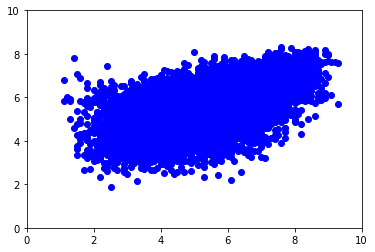

In [27]:
plt.scatter(y_test, y_predict3, color = 'b')
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.show()

In [28]:
regr2 = RandomForestRegressor(n_estimators=20, random_state = 42)
regr2.fit(pca_transformed_train, y_train)
y_predict4 = regr2.predict(pca_transformed_test)
r2_score(y_test, y_predict4)

0.41544946137788996

In [29]:
import datetime
start = datetime.datetime.now()
regr5 = RandomForestRegressor(n_estimators=50, random_state = 42)
regr5.fit(pca_transformed_train, y_train)
y_predict5 = regr5.predict(pca_transformed_test)
r2_score(y_test, y_predict5)
end = datetime.datetime.now()
print(start, end)

2021-09-12 14:01:35.103560 2021-09-12 14:20:06.596631


In [30]:
r2_score(y_test, y_predict5)

0.4336829141720374

In [31]:
import datetime
start = datetime.datetime.now()
regr6 = RandomForestRegressor(n_estimators=100, random_state = 42)
regr6.fit(pca_transformed_train, y_train)
y_predict6 = regr6.predict(pca_transformed_test)
print(r2_score(y_test, y_predict6))
end = datetime.datetime.now()
print(start, end)

0.4400680975327974
2021-09-12 14:31:32.373955 2021-09-12 15:15:37.233901


**Note: From above, it can be concluded that the Random Forest Regressor model performance is better than Linear Regresson model, though one can not rely on the model performance as the r2 score very low. We need to improve this.** 

# Gradient boosting 

In [32]:
def opt_gradientboosting(learning_rate, n_estimator, max_features, max_depth):
    for rate in learning_rate:
        gb = GradientBoostingRegressor(learning_rate = rate, n_estimators = n_estimator,  max_features = max_features, max_depth = max_depth)
        gb.fit(pca_transformed_train, y_train)
        y_gb_predict = gb.predict(pca_transformed_test)
        score_1 = r2_score(y_test,y_gb_predict)
        print(rate)
        print(score_1)
    return print('End')


In [33]:
learning_rate = [0.1, 1, 1.5, 2]
opt_gradientboosting(learning_rate, 10, 3, 3)

0.1
0.17007034476247018
1
0.2715551621235459
1.5
0.17958358397457697
2
-0.029063274049654586
End


In [35]:
# As the run time was very long with GridSearchCV, hence run was abrupted and hyperparameter search was carried in steps tuning one parameter at a time.


#gbr2 = GradientBoostingRegressor()
#learning_rate = [0.1, 1]
#n_estimators = [10, 50, 100, 200]
#max_features = [3, 5]
#max_depth = [3, 5]
#parameters = {'learning_rate': learning_rate, 'n_estimators': n_estimators, 'max_features': max_features,'max_depth': max_depth}
#grid_search2 = GridSearchCV(estimator = gbr2, param_grid = parameters, scoring = 'r2', cv = 5 )
#grid_search2.fit(pca_transformed_train, y_train)
#print(grid_search2.best_score_)
#print(grid_search2.best_params_)

In [36]:
start = datetime.datetime.now()
gbr4 = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 100, max_features= 283 , max_depth = 5)
gbr4.fit(pca_transformed_train, y_train)
y_train_predict4 = gbr4.predict(pca_transformed_train)
y_test_predict4 = gbr4.predict(pca_transformed_test)
score_1 = r2_score(y_test,y_test_predict4)
end = datetime.datetime.now()
print(score_1)
print(start, end)

0.47868483587718125
2021-09-12 15:58:19.017190 2021-09-12 16:24:31.654532


In [37]:
start = datetime.datetime.now()
gbr4 = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 100, max_features= 283 , max_depth = 7)
gbr4.fit(pca_transformed_train, y_train)
y_train_predict4 = gbr4.predict(pca_transformed_train)
y_test_predict4 = gbr4.predict(pca_transformed_test)
score_1 = r2_score(y_test,y_test_predict4)
end = datetime.datetime.now()
print(score_1)
print(start, end)

0.4847577214278799
2021-09-12 16:39:02.803331 2021-09-12 17:05:29.561079


In [39]:
start = datetime.datetime.now()
gbr4 = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 500, max_features= 283 , max_depth = 7)
gbr4.fit(pca_transformed_train, y_train)
y_train_predict4 = gbr4.predict(pca_transformed_train)
y_test_predict4 = gbr4.predict(pca_transformed_test)
score_1 = r2_score(y_test,y_test_predict4)
end = datetime.datetime.now()
print(score_1)
print(start, end)

0.47779204783692053
2021-09-13 00:26:00.661775 2021-09-13 02:03:34.331854


**Model performance is decreasing and run time is increasing with increase in n_estimators, hence no further optimization was carried out and stopped here.** 

# Summary:

The default PCA was applied and 95% features were taken for model building. Linear Regression model performance improved resonably as compared to without PCA.  

However the other models Random Forest Regressor and Gradient Boosting Regressor performance didn't improve and run-time increased significantly. The r2_score: 0.477 was less as comaped to non-PCA case where r2_score: 0.50.